#                                                   Modelisation:

# XGBoost: 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc
import shap
import matplotlib.pyplot as plt

/Users/khadijaaassi/Desktop/Simplon/Projet_devIA/Simplon_SBA-modelisation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df=pd.read_csv('/Users/khadijaaassi/Desktop/Simplon/Projet_devIA/Simplon_SBA-modelisation/data/cleaned_data.csv')

In [3]:
label_encoders = {}
categorical_cols = ['Zip', 'State', 'Bank', 'BankState', 'RevLineCr', 'LowDoc', 'MIS_Status']

In [4]:
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le 

In [5]:
features = ['State', 'NAICS', 'ApprovalFY', 'NewExist', 'CreateJob', 'RetainedJob', 
            'FranchiseCode', 'UrbanRural', 'LowDoc', 'GrAppv', 'SBA_Appv', 'Bank', 'Term']


X = df[features] 
y = df['MIS_Status']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y)


1ere modélisation, avec un score plutôt pas mal.

In [6]:
# Création du modèle XGBoost
model = xgb.XGBClassifier(objective="multi:softmax", num_class=3, max_depth=3, learning_rate=0.2, n_estimators=100)

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle : {accuracy:.4f}")


Précision du modèle : 0.9372


J'ai besoin de faire un fine tuning, regarder un peu plus la doc pour mieux comprendre les implications et utisation du model.

In [7]:
# Assuming y_true are the actual labels and y_pred are the predicted labels
y_pred = model.predict(X_test)
y_pred_labels = np.round(y_pred)  # Convert probabilities to class labels (for binary classification)

# Metrics
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels, average='weighted')  # 'weighted' for multi-class
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')


Accuracy: 0.9372
Precision: 0.9356
Recall: 0.9372
F1 Score: 0.9359
ROC AUC Score: 0.8716


In [8]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.86      0.77      0.81     15782
           1       0.95      0.97      0.96     74135

    accuracy                           0.94     89917
   macro avg       0.90      0.87      0.89     89917
weighted avg       0.94      0.94      0.94     89917



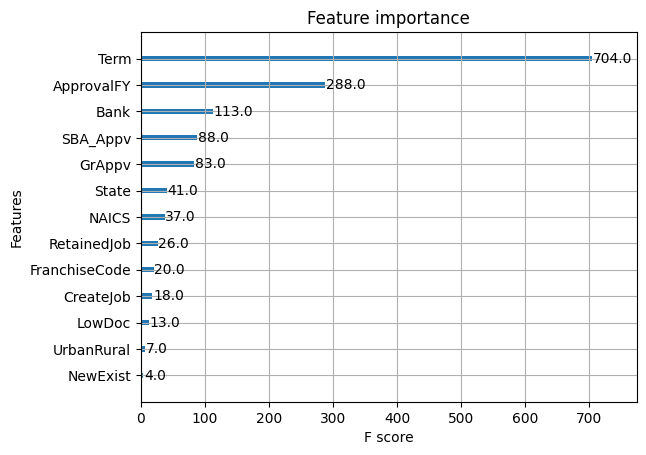

In [9]:
xgb.plot_importance(model)
plt.show()


In [11]:
import xgboost as xgb

# Convert data into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define cross-validation parameters
params = {
    'objective': 'binary:logistic',  # Change this for regression or multi-class classification
    'eval_metric': 'logloss'
}

cv_results = xgb.cv(params, dtrain, num_boost_round=100, nfold=5, metrics="logloss", as_pandas=True)

# Print CV results
print(cv_results)


    train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0             0.353392           0.000852           0.353550          0.000454
1             0.293433           0.000820           0.293678          0.000564
2             0.259316           0.000844           0.259574          0.000755
3             0.235995           0.000895           0.236305          0.001338
4             0.218276           0.000929           0.218642          0.001173
..                 ...                ...                ...               ...
95            0.125536           0.000304           0.133057          0.001053
96            0.125320           0.000302           0.132912          0.001057
97            0.125220           0.000337           0.132866          0.001072
98            0.125027           0.000303           0.132739          0.000996
99            0.124860           0.000329           0.132633          0.001008

[100 rows x 4 columns]


## BEST MODEL!


Matrice de confusion :
[[13194  2588]
 [ 1821 72314]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     15782
           1       0.97      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.91      0.91     89917
weighted avg       0.95      0.95      0.95     89917

ROC AUC Score: 0.9801

Feature Importance (XGBoost) :
State: 0.0161
NAICS: 0.0139
ApprovalFY: 0.1191
NewExist: 0.0148
RetainedJob: 0.0140
FranchiseCode: 0.0355
UrbanRural: 0.0376
GrAppv: 0.0213
SBA_Appv: 0.0259
Bank: 0.0241
Term: 0.2429
ApprovalFY_Term_Ratio: 0.4346


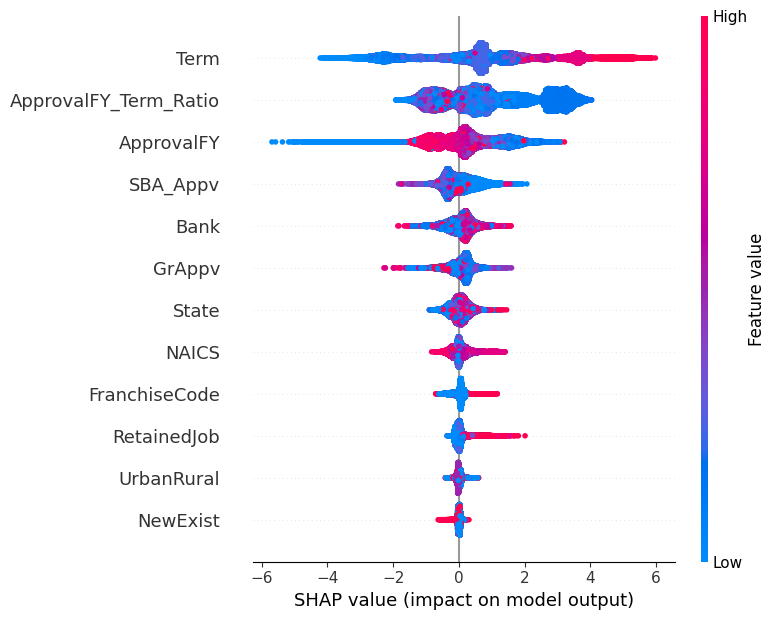

In [12]:
# Standardisation des colonnes monétaires
monetary_cols = ['GrAppv', 'SBA_Appv', 'DisbursementGross']
scaler = StandardScaler()
df[monetary_cols] = scaler.fit_transform(df[monetary_cols])

# Création de nouvelles features (interactions entre variables)
# df['GrAppv_Term_Ratio'] = df['GrAppv'] / (df['Term'] + 1)
# df['SBA_Appv_Term_Ratio'] = df['SBA_Appv'] / (df['Term'] + 1)
df['ApprovalFY_Term_Ratio'] = df['ApprovalFY'] / (df['Term'] + 1)

# Séparation des features et de la cible
features = ['State', 'NAICS', 'ApprovalFY', 'NewExist', 'RetainedJob', 
            'FranchiseCode', 'UrbanRural', 'GrAppv', 'SBA_Appv', 'Bank', 'Term',
            'ApprovalFY_Term_Ratio']
X = df[features]
y = df['MIS_Status']

# Vérification du déséquilibre des classes
class_counts = y.value_counts()
scale_pos_weight = class_counts[0] / class_counts[1] if class_counts[1] != 0 else 1

# Séparation en train/test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y)

# Définition du modèle XGBoost avec hyperparamètres ajustés pour améliorer le F1-score de la classe 0
best_model = xgb.XGBClassifier(
    max_depth=6,  # Augmenter la profondeur pour capturer plus de complexité
    learning_rate=0.15,  # Ajuster le taux d'apprentissage
    n_estimators=250,  # Augmenter le nombre d'estimateurs
    subsample=0.9,  # Légère augmentation de la sous-sampling
    colsample_bytree=0.9,  # Utiliser plus de features par arbre
    scale_pos_weight=scale_pos_weight * 1.4  # Ajuster pour améliorer la détection de la classe 0
)
{'max_depth': 10, 'learning_rate': 0.1362428548659794, 'n_estimators': 362,
  'subsample': 0.973051842684875, 'colsample_bytree': 0.8460830471606468, 'scale_pos_weight': 1.075431778029177}
# Entraînement du modèle
best_model.fit(X_train, y_train)

# Ajustement du seuil de classification
threshold = 0.25  # Ajustement pour mieux détecter la classe 0
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba > threshold).astype(int)

# Prédictions et évaluation
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

# Score ROC AUC (uniquement si binaire)
if len(np.unique(y_test)) == 2:
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f'ROC AUC Score: {roc_auc:.4f}')

# Importance des features avec XGBoost
print("\nFeature Importance (XGBoost) :")
feature_importances = best_model.feature_importances_
for col, importance in zip(features, feature_importances):
    print(f'{col}: {importance:.4f}')

# SHAP pour interprétabilité
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


# Optuna

In [ ]:
df['ApprovalFY_Term_Ratio'] = df['ApprovalFY'] / (df['Term'] + 1)

# Séparation des features et de la cible
features = ['State', 'NAICS', 'ApprovalFY', 'NewExist', 'RetainedJob', 
            'FranchiseCode', 'UrbanRural', 'GrAppv', 'SBA_Appv', 'Bank', 'Term',
            'ApprovalFY_Term_Ratio']
X = df[features]
y = df['MIS_Status']

In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score

# Définition de la fonction objectif pour Optuna
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, 3.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
    }
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return roc_auc_score(y_test, y_pred, average='weighted')


# Chargement des données (à adapter si nécessaire)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y)

# Lancer l'optimisation Optuna
study = optuna.create_study(direction='maximize', study_name="Xgbm_study5", storage="sqlite:///optuna_study.db")
study.optimize(objective, n_trials=50)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", study.best_params)

# Entraîner le modèle avec les meilleurs paramètres
best_params = study.best_params
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Prédictions et évaluation finale
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

# Calcul et affichage du ROC AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print(f'ROC AUC Score: {roc_auc:.4f}')


## Optuna 2

In [13]:

# Séparation des features et de la cible
features = ['State', 'NAICS',  'NewExist', 'RetainedJob', 
            'FranchiseCode', 'UrbanRural', 'GrAppv', 'Bank', 'Term',
            ]
X = df[features]
y = df['MIS_Status']

In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score

# Définition de la fonction objectif pour Optuna
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, 3.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
    }
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return roc_auc_score(y_test, y_pred, average='weighted')


# Chargement des données (à adapter si nécessaire)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y)

# Lancer l'optimisation Optuna
study = optuna.create_study(direction='maximize', study_name="Xgbm_study6", storage="sqlite:///optuna_study.db")
study.optimize(objective, n_trials=50)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", study.best_params)

# Entraîner le modèle avec les meilleurs paramètres
best_params = study.best_params
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Prédictions et évaluation finale
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

# Calcul et affichage du ROC AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print(f'ROC AUC Score: {roc_auc:.4f}')


## Model 1

Sans ApprovalFY et SBA_Approval

In [22]:
# Standardisation des colonnes monétaires
monetary_cols = ['GrAppv', 'DisbursementGross']
scaler = StandardScaler()
df[monetary_cols] = scaler.fit_transform(df[monetary_cols])

# Séparation des features et de la cible
features = ['State', 'NAICS', 'NewExist', 'RetainedJob', 
            'FranchiseCode', 'UrbanRural', 'GrAppv', 'Bank', 'Term',
            ]
X = df[features]
y = df['MIS_Status']

# Vérification du déséquilibre des classes
class_counts = y.value_counts()
scale_pos_weight = class_counts[0] / class_counts[1] if class_counts[1] != 0 else 1

# Séparation en train/test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y)

# Définition du modèle XGBoost avec hyperparamètres ajustés pour améliorer le F1-score de la classe 0
best_model = xgb.XGBClassifier(
    max_depth=6,  # Augmenter la profondeur pour capturer plus de complexité
    learning_rate=0.15,  # Ajuster le taux d'apprentissage
    n_estimators=250,  # Augmenter le nombre d'estimateurs
    subsample=0.9,  # Légère augmentation de la sous-sampling
    colsample_bytree=0.9,  # Utiliser plus de features par arbre
    scale_pos_weight=scale_pos_weight * 1.4  # Ajuster pour améliorer la détection de la classe 0
)
{'max_depth': 10, 'learning_rate': 0.1362428548659794, 'n_estimators': 362,
  'subsample': 0.973051842684875, 'colsample_bytree': 0.8460830471606468, 'scale_pos_weight': 1.075431778029177}
# Entraînement du modèle
best_model.fit(X_train, y_train)

# Ajustement du seuil de classification
threshold = 0.25  # Ajustement pour mieux détecter la classe 0
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba > threshold).astype(int)


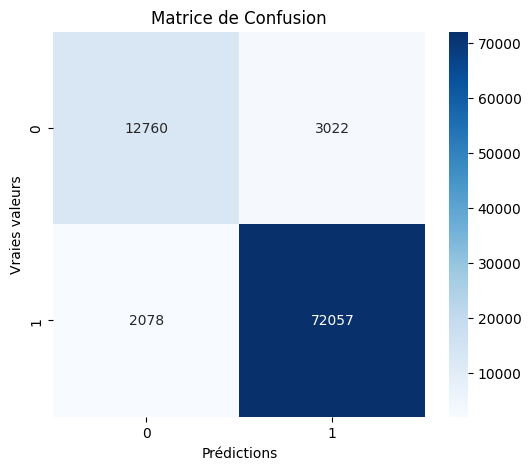

In [23]:
# Matrice de confusion en heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()

In [24]:
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))



Rapport de classification :
              precision    recall  f1-score   support

           0       0.86      0.81      0.83     15782
           1       0.96      0.97      0.97     74135

    accuracy                           0.94     89917
   macro avg       0.91      0.89      0.90     89917
weighted avg       0.94      0.94      0.94     89917



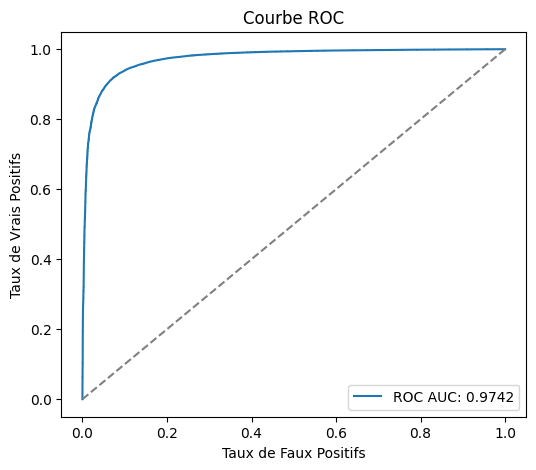

In [25]:
# Calcul et affichage du ROC AUC Score
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC: {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()


Feature Importance (XGBoost) :


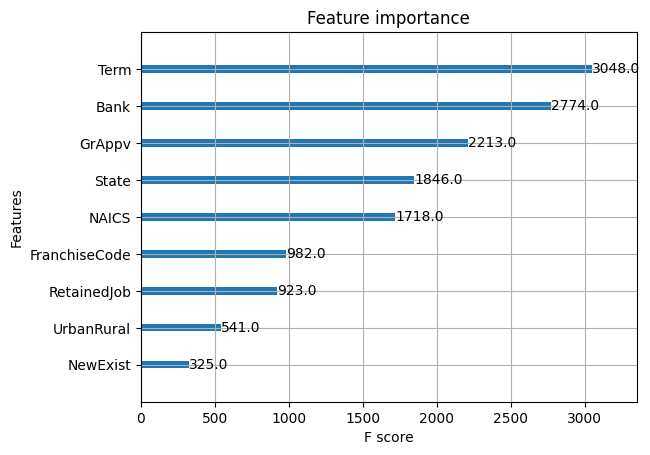

In [26]:
# Importance des features avec XGBoost
print("\nFeature Importance (XGBoost) :")

xgb.plot_importance(best_model)
plt.show()

# feature_importances = best_model.feature_importances_
# for col, importance in zip(features, feature_importances):
#     print(f'{col}: {importance:.4f}')

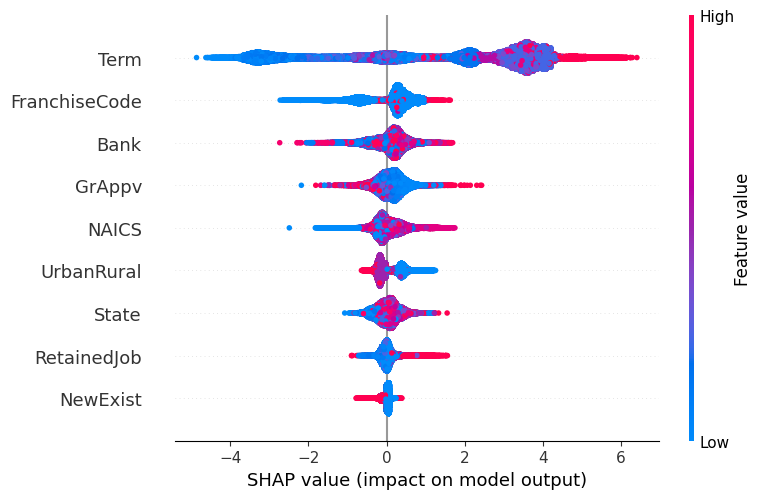

In [27]:

# SHAP pour interprétabilité
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


## Model 2

Je rajoute les années de crise

In [15]:
annee_crise = [1960,1961,1969,1970,1973,1974,1980,1981,1982,2000,2001,2007,2008]
df['Crisis'] = df['ApprovalFY'].apply(lambda x : 1 if x in annee_crise else 0)

In [16]:
# Standardisation des colonnes monétaires
monetary_cols = ['GrAppv', 'DisbursementGross']
scaler = StandardScaler()
df[monetary_cols] = scaler.fit_transform(df[monetary_cols])

# Séparation des features et de la cible
features = ['State', 'NAICS', 'NewExist', 'RetainedJob', 
            'FranchiseCode', 'UrbanRural', 'GrAppv', 'Bank', 'Term', 'Crisis'
            ]
X = df[features]
y = df['MIS_Status']

# Séparation en train/test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y)

# Définition du modèle XGBoost avec hyperparamètres ajustés pour améliorer le F1-score de la classe 0
best_model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.15,
    n_estimators=250,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=scale_pos_weight * 1.4
)
# {'max_depth': 10, 'learning_rate': 0.1362428548659794, 'n_estimators': 362,
#   'subsample': 0.973051842684875, 'colsample_bytree': 0.8460830471606468, 'scale_pos_weight': 1.075431778029177}
# Entraînement du modèle
best_model.fit(X_train, y_train)

# Ajustement du seuil de classification
# threshold = 0.25  # Ajustement pour mieux détecter la classe 0
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba > threshold).astype(int)



Matrice de confusion :


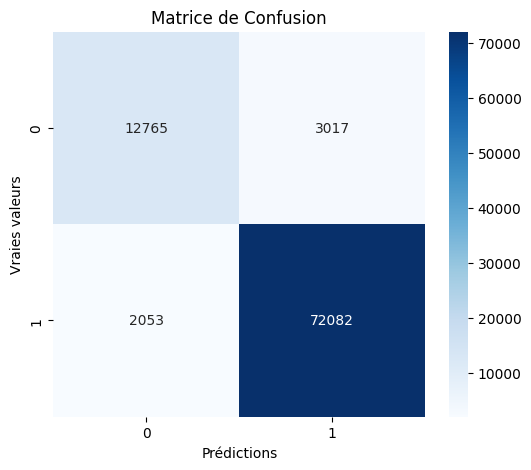

In [ ]:
# Matrice de confusion en heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()


In [18]:
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))



Rapport de classification :
              precision    recall  f1-score   support

           0       0.86      0.81      0.83     15782
           1       0.96      0.97      0.97     74135

    accuracy                           0.94     89917
   macro avg       0.91      0.89      0.90     89917
weighted avg       0.94      0.94      0.94     89917



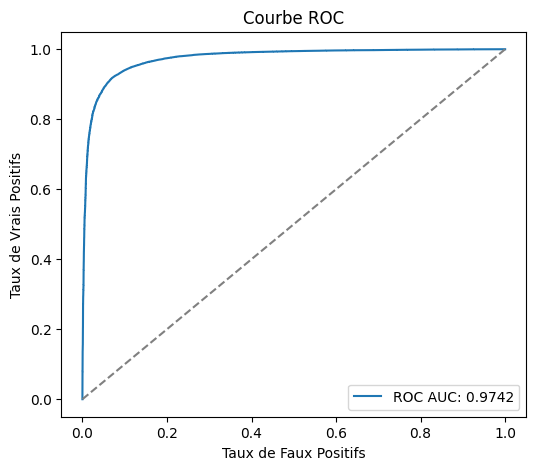

In [ ]:
# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC: {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()


Feature Importance (XGBoost) :


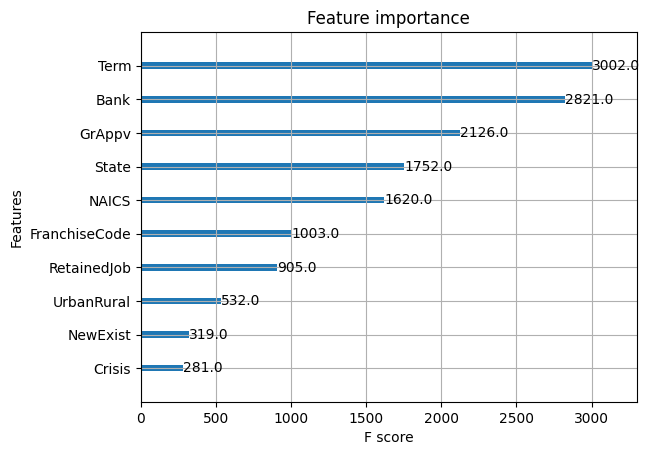

In [ ]:
# Importance des features avec XGBoost
print("\nFeature Importance (XGBoost) :")

xgb.plot_importance(best_model)
plt.show()

# feature_importances = best_model.feature_importances_
# for col, importance in zip(features, feature_importances):
#     print(f'{col}: {importance:.4f}')


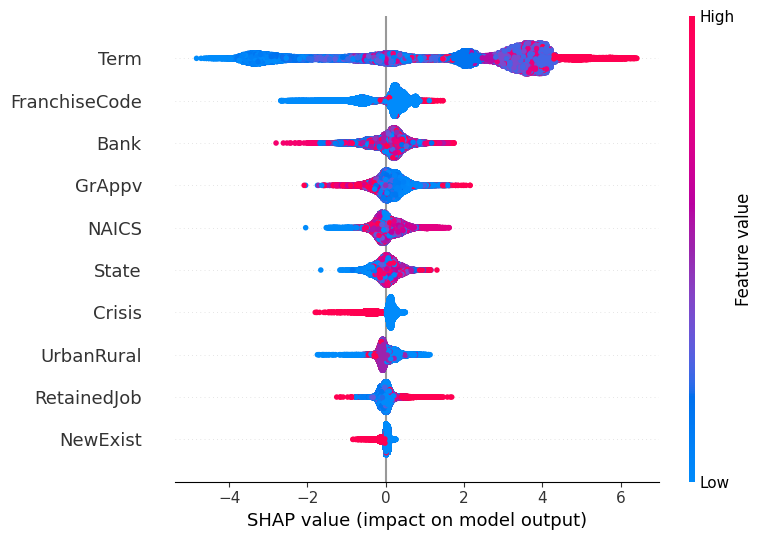

In [21]:
# SHAP pour interprétabilité
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

PAS D'AMÉLIORATION!!